<h1>DSCI 100 Group Project: Predicting Heart Diseases Based on Age and Maximum Heart Rate</h1>

<h2>Introduction</h2>

Heart disease is a term that applies to any abnormal functioning of the heart (Chambers, 2021). It is estimated to effect around 2.5% of the worldwide population (Chambers, 2021), making the ability to diagnose heart disease a global issue. 
Our group project will be utilizing the UCI Cleveland Heart Disease dataset (Aha, 1988) <mark>(Janosi et al., 1988)</mark>, which has been preprocessed. This dataset tracks various risk factors that individuals with heart disease have, such as: 

(1) Age (age)

(8) Maximum Heart Rate of the patient (thalach): measures the fastest recorded rate of the patient's heart in beats per minute (bpm). 

(14) Diagnosis of heart disease (num): states whether the patient was given the status of having an angiographic disease. 
    
    No = no heart disease
    
    Yes = heart disease

This data can have a tremendous impact on the ability to diagnose heart disease and identify risk factors in individuals who have not yet presented with heart disease. Our group will be answering the predictive question: **Can we predict a diagnosis of heart disease based on an individual's age and maximum heart rate?**

<h2>Method</h2>
To complete our data analysis, we will be using K -nearest neighbors classification. Through cross-validation of the training dataset, we will choose the optimal K. which we will use to train our data. The class we will be predicting is the variable num, which gives the diagnosis of heart disease based on angiographic disease status. The variables that we will use to predict the class are age (years), and  maximum heart rate (bpm). We will then use the testing data set to evaluate the accuracy of our model. If the accuracy is above 90% accuracy, then our chosen variable of age and maximum heart rate will be a significant contributor to the diagnosis of heart disease.  


<h2>Expected Outcomes and Significance</h2>
Individuals with a higher age range have a higher risk of having heart disease, and a higher heart disease related mortality rate (Whitman, et al., 2019; Nichols, et al. 2013). Furthermore, inablilty to reach an age predicted maximum heart rate is also an indicator of heart disease (Whitman, et al., 2019). By conducting data analysis, it will be helpful in assisting the diagnosis of heart disease. Having a classification model which predicts heart diseases based on age and heart rate can greatly reduce the medical resources used to formally diagnose such diseases. For example, if the model indicates a 99% chance of a negative diagnosis on a patient, and without other symptoms present, it could be an indication that the patient is healthy. Furthermore, the model can be used as an indicator for patients to receive formal medical attention and formal medical treatment, which could help with an early-stage diagnosis of certain heart diseases, and treat those diseases in a time-efficient manner. As seen in the data set, it could lead to discovering more factors that could result in heart diseases, such as cholesterol levels, smoking, history of diabetes and coronary heart disease, and more. 


<h2>Results</h2>

<h3>Loading relevant Library</h3>

In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

<h3>Reading & Wrangling our dataset from the web into R</h3>

In [27]:
#reading and cleaning the data
cleveland_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", "sex", "cp", "trestbps", 
                                         "chol", "fbs", "restecg", "thalach", 
                                         "exang", "oldpeak", "slope", "ca", "thal", "num")) 
cleveland_data <- cleveland_data |>
    mutate(num = case_when(num %in% c(1, 2, 3, 4) ~ "Yes", num %in% 0 ~ "No"))

#selecting the important variables
cleveland_data_reduced <- cleveland_data |>
    select(age, thalach, num)
cleveland_data_reduced

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,thalach,num
<dbl>,<dbl>,<chr>
63,150,No
67,108,Yes
67,129,Yes
⋮,⋮,⋮
57,115,Yes
57,174,Yes
38,173,No


**Commentary:** This table is a reduced version of the dataset, containing only the values that we will be using during this analysis; age, thalach, and num.

<h3>Summarizing the Training Data</h3>

In [28]:
#setting the seed
set.seed(2002) #do not change this!!!

#spliting the data
cleveland_split <- initial_split(cleveland_data_reduced, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

#creating a summary table
summary_table <- cleveland_training |>
    summarize(age_mean = mean(age, na.rm = TRUE), thalach_mean = mean(thalach, na.rm = TRUE),
             age_sd = sd(age, na.rm = TRUE), thalach_sd = sd(thalach, na.rm = TRUE))

<div align="center"> Table 1: Mean & Standard Devation Statistics for each predictor</div>

|                  |     Mean|      S.D|
|-----------------:|--------:|--------:|
|               Age| 54.33921|  8.70329|
|Maximum Heart Rate| 148.9515| 22.24606|

**Commentary:** This table is a summary table that depicts the mean age and mean heart rate of the individual observations in the dataset, as well as the standard deviation of the age and heart rate. This gives us an idea of the shape of our dataset.

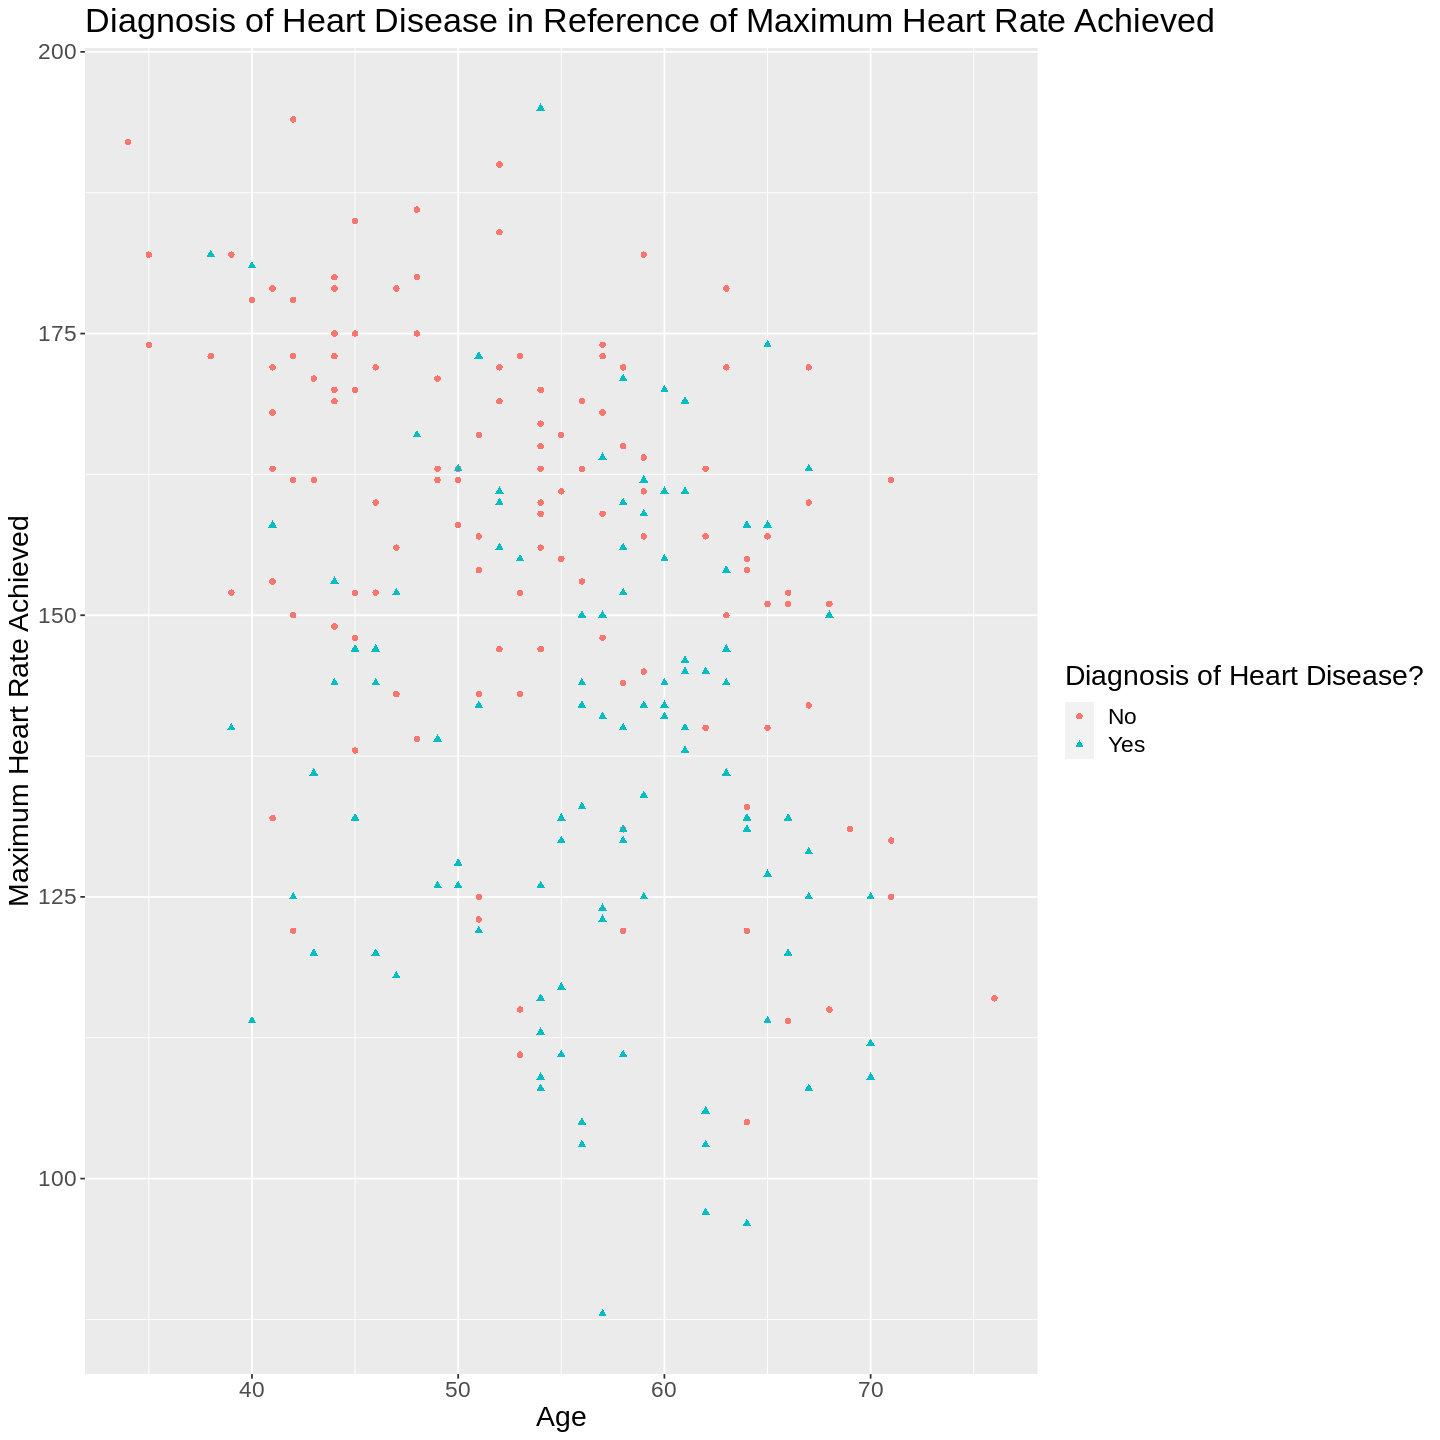

In [5]:
#scaling the reduced data
cleveland_data_scaled <- cleveland_training |>
    mutate(scaled_age = scale(age, center = TRUE), 
           scaled_thalach = scale(thalach, center = TRUE))

options(repr.plot.width = 12, repr.plot.height = 12)

#create a graph of reduced dataset
plot <- cleveland_training |>
    ggplot(aes(x = age, y = thalach, color = num, shape = num)) +
    geom_point() + 
    labs(x = "Age", y = "Maximum Heart Rate Achieved", color = "Diagnosis of Heart Disease?", 
         shape = "Diagnosis of Heart Disease?") +
    ggtitle("Diagnosis of Heart Disease in Reference of Maximum Heart Rate Achieved") +
    theme(text = element_text(size = 17))
plot

**Commentary:** This graph is a scatterplot of maximum heart rate vs age, with the diagnosis of heart disease displayed via colour and shape. As can be seen in the graph, the relationship between heart rate and age appears to be <mark>linear</mark>, though not very strong. Furthermore, there appears to be a weak relationship between heart rate and heart disease diagnosis, as the higher the maximum heart rate the less likely a diagnosis of heart disease.


<h3>Selecting Best K-Value for Model</h3>

In [6]:
set.seed(2002)

#perform cross validation
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = num)

#create a recipe for cleveland
cleveland_recipe <- recipe(num ~ age + thalach , data = cleveland_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

#create a model to find best k value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#create a workflow to find best k
knn_results <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cleveland_vfold, grid = 10) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

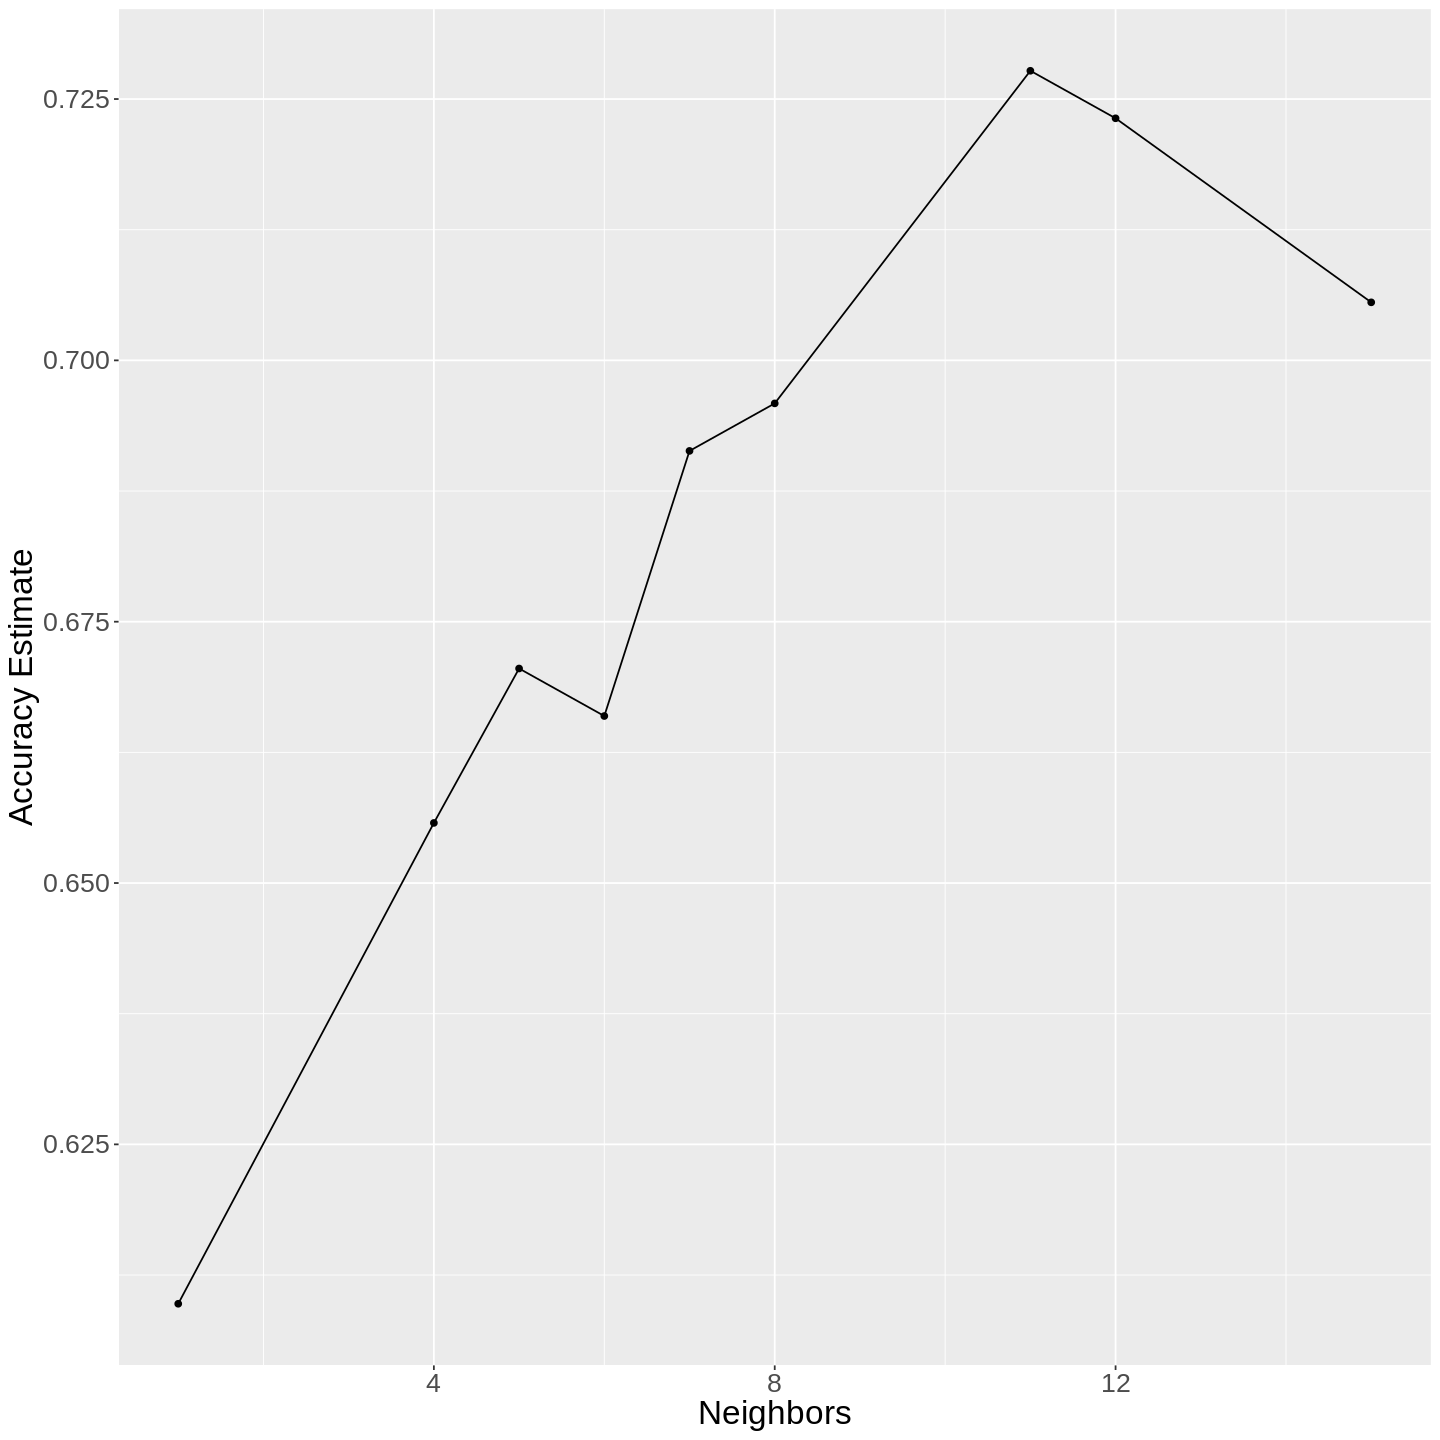

In [7]:
#plot k values against their respective accuracies and choose optimal k value
cleveland_cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cleveland_cross_val_plot

**Commentary:** This is the graph of our cross-validation, to determine what the best value of k is for our model. As can be seen from the graph, k=11 is the best k-value, because it has the highest accuracy compared to the other k-values. 

<h3>Perform $K$-nearest neighbors Classification</h3>

In [11]:
#perform KNN-classification with best k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
set_engine("kknn") |>
set_mode("classification")

#fit into training data
cleveland_fit <- workflow() |>
add_recipe(cleveland_recipe) |>
add_model(knn_best_spec) |>
fit(cleveland_training)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2907489
Best kernel: rectangular
Best k: 11

In [12]:
#predict observations using testing data
cleveland_test_predictions <- cleveland_fit |>
    predict(cleveland_testing) |>
    bind_cols(cleveland_testing) |>
    mutate(num = as.factor(num))
cleveland_test_predictions

.pred_class,age,thalach,num
<fct>,<dbl>,<dbl>,<fct>
No,37,187,No
No,56,178,No
Yes,62,160,Yes
⋮,⋮,⋮,⋮
No,68,141,Yes
Yes,57,115,Yes
No,57,174,Yes


**Commentary:** This table shows the predicted diagnoses of heart disease in comparison to the actual diagnosis. As can be seen, the model correctly predicts four of the six observations that are visible in the table, and incorrectly predicts two observations.

In [13]:
#compare the accuracy of predictions to the true values in the test set
cleveland_acc <- cleveland_test_predictions |> 
    metrics(truth = num, estimate = .pred_class) |>
    select(.metric, .estimate) |> 
    head(1)
cleveland_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.6842105


**Commentary:** This tibble shows the accuracy of the model.

<h2>Discussion</h2>

**Summary:** Our projects aim was to determine if we could train a model to make an accurate diagnosis of heart disease based on the variables age and maximum heart rate. To accomplish this task, we split our data into a training and testing set, and performed cross-validation on our training data to determine the best k-value for our KNN-classification. This value was determined to be k=11, and therefore we performed KNN-nearset neighbours with k=11. After this we fit our model to the testing data, and determined the accuracy of the predictions the model made. Our accuracy was 68%, which is not high enough to significantly contribute to a diagnosis of heart disease.

**Expectations:** The results were somewhat unexpected. We expected age and maximum heart rate to be a significant predictor, since research have showed heart diseases increase with age (Jousilahti et al., 1999). Researchers have also found that increased resting heart rate multiplies risk of the cardiovascular disease (Custodis et al., 2013). While 68% signfies a major percentage of people diagnosed with heart diseases, it is not high enough to significantly contribute to a diagnosis of hear disease. Thus, the results were somewhat unexpected, as we expected the results to have high accuracy, but the accuracy were not high enough to make an accurate diagnosis.

**Future Questions:** Since the results have lead to the conclusion that age and maximum heart rate of patients are not significant predictors for the diagnosis of heart diseases, for future data analysis using classification we could ask the questions:
1. Are sex, chest pain type, resting blood pressure, cholesterol Level, fasting blood sugar or resting electrocardiographic result able to predict the diagnosis of heart diseases with high accuracy?
1. Which pair of variables in the dataset have the highest accuracy in predicting the diagnosis of heart diseases?
1. With the rapid development of technologies that can increase the life expectancy of patients with heart diseases, how can we add new data on heart disease variables to better predict the diagnosis of heart diseases?

<h2>References</h2>

Aha, D. W. (1988). Heart Disease Data Set [Data set]. UCI: Machine Learning Repository.   https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Chambers, J. B. (2021). Epidemiology of valvular heart disease. In C. M. Otto & R. O. Bonow (Eds.), Valvular Heart Disease: A    Companion to Braunwald’s Heart Disease, Fifth Edition (pp. 1-21). Elsevier, Inc. 

Holmes, J. S., Arispe, I. E., & Moy, E. (2005). Heart Disease and Prevention: Race and Age Differences in Heart Disease          Prevention, Treatment, and Mortality. Medical Care, 43(3), 133-141. https://www.jstor.org/stable/3768236 

Nichols, M., Townsend, N., Scarborough, P., & Rayner, M. (2013). Trends in age-specific coronary heart disease mortality in the  European Union over three decades: 1980-2009. European Heart Journal, 34(39), 3017-3027.   https://doi.org/10.1093/eurheartj/eht159 

Whitman, M., Jenkins, C., Sabapathy, S., & Adams, L. (2019). Comparison of Heart Rate Blood Pressure Product Versus Age-        Predicted Maximum Heart Rate as Predictors of Cardiovascular Events During Exercise Stress Echocardiography. The American      Journal of Cardiology, 124(4), 528-533. https://doi.org/10.1016/j.amjcard.2019.05.027 

Jousilahti, P., Vartiainen, E., Tuomilehto, J., &amp; Puska, P. (1999). Sex, age, cardiovascular risk factors, and coronary heart disease. Circulation, 99(9), 1165–1172. https://doi.org/10.1161/01.cir.99.9.1165 

Janosi, A., Steinbrunn, W., Pfisterer, M., &amp; Detrano, R. (1988). Retrieved 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. 

Custodis, F., Reil, J.-C., Laufs, U., &amp; Böhm, M. (2013). Heart rate: A global target for cardiovascular disease and therapy along the Cardiovascular Disease Continuum. Journal of Cardiology, 62(3), 183–187. https://doi.org/10.1016/j.jjcc.2013.02.018 
